Importation des modules

In [120]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import feature_selection
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,precision_recall_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import pickle as pk
import numpy as np

Importation des données

In [121]:
data_prof = pd.read_csv('Data_Arbre.csv')

Selection des données que nous allons utiliser
Remplacement de l'etat Essouché par 1, 0 sinon

In [122]:
cols = ["fk_arb_etat","tronc_diam","haut_tot","fk_stadedev","age_estim", "clc_quartier", "feuillage", "fk_port", "fk_nomtech"]
data = data_prof[cols]

data.loc[data["fk_arb_etat"] == "Essouché", "fk_arb_etat"] = 1
data.loc[data["fk_arb_etat"] != 1, "fk_arb_etat"] = 0
data.fk_arb_etat = data.fk_arb_etat.astype(int)
# data.fk_arb_etat.value_counts()

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_19072\4068205935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fk_arb_etat = data.fk_arb_etat.astype(int)


Encodage des valeurs qualitatives

In [123]:
#Encodage
encoder = OrdinalEncoder()
lst_col = ['fk_stadedev', 'clc_quartier', 'feuillage', 'fk_port', 'fk_nomtech']

temp = data[lst_col]

data[lst_col] = encoder.fit_transform(temp)

C:\Users\Alexandre\AppData\Local\Temp\ipykernel_19072\1937204942.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[lst_col] = encoder.fit_transform(temp)


Repartition des données en Test et Train

In [124]:
X_data = data.drop(columns=["fk_arb_etat"])
Y_data = data["fk_arb_etat"]

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

Recherche des meilleurs paramètres pour le model RandomForestClassifier

In [125]:
rndforest = RandomForestClassifier(n_estimators=100, random_state=42)
rndforest.fit(X_train, Y_train)
gsearch = GridSearchCV(estimator = rndforest, param_grid = {'n_estimators':[i*25 for i in range(1,20)]}, cv=5, n_jobs=-1)
best_model = gsearch.fit(X_train, Y_train)

In [126]:
print(gsearch.best_estimator_)

RandomForestClassifier(n_estimators=300, random_state=42)


In [127]:
score = cross_val_score(best_model, X_train, Y_train, cv=5, n_jobs=-1)

In [128]:
print(np.mean(score))

0.9755355376722807


Feature selection

In [129]:
forest_feature = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
forest_feature.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [130]:
# Extract feature importances
importances = forest_feature.feature_importances_

cols_lst_feature = ["tronc_diam","haut_tot","fk_stadedev","age_estim", "clc_quartier", "feuillage", "fk_port", "fk_nomtech"]

feature_names = data[cols_lst_feature].columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

In [131]:
# Rank features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

        Feature  Importance
0    tronc_diam    0.349883
1      haut_tot    0.196485
7    fk_nomtech    0.184434
3     age_estim    0.104227
4  clc_quartier    0.103364
6       fk_port    0.031535
2   fk_stadedev    0.018711
5     feuillage    0.011361


In [132]:
# Select top N features (example selecting top 10 features)
top_features = feature_importance_df['Feature'][:5].values
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [133]:
featured_model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
featured_model.fit(X_train_selected, Y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

Matrice de confusion

[[0.99671678 0.00328322]
 [0.92142857 0.07857143]]


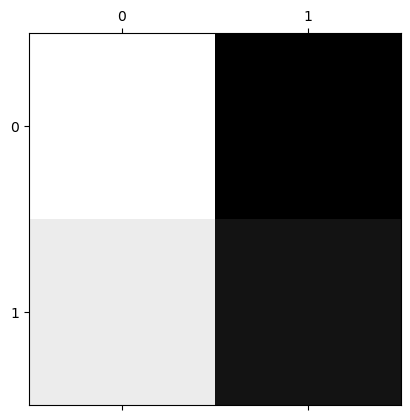

In [134]:
import matplotlib.pyplot as plt
classes = cross_val_predict(featured_model, X_train_selected, Y_train, cv=3, n_jobs=-1)
# print(classes)
matrice = confusion_matrix(Y_train, classes, normalize='true')

print(matrice)
plt.matshow(matrice,cmap=plt.cm.gray)

In [135]:
# print(matrice)
# plt.matshow(matrice,cmap=plt.cm.gray)

SMOTE

In [182]:
sm = SMOTE(random_state=42, n_jobs=-1, sampling_strategy=0.25)
X_smote, Y_smote = sm.fit_resample(X_train, Y_train)

c:\Users\Alexandre\anaconda3\Lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [183]:
Y_smote.value_counts()

fk_arb_etat
0    5787
1    1446
Name: count, dtype: int64

In [184]:
smoted_model = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
smoted_model.fit(X_smote, Y_smote)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

[[0.99032314 0.00967686]
 [0.1120332  0.8879668 ]]


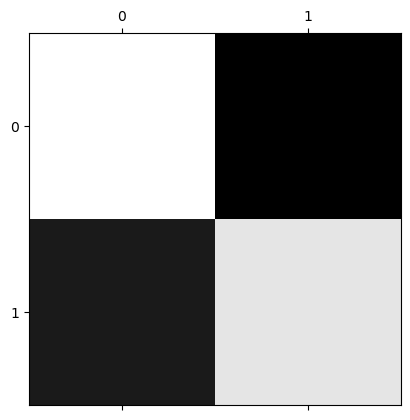

In [185]:
classes = cross_val_predict(smoted_model, X_smote, Y_smote, cv=3, n_jobs=-1)
# print(classes)
matrice = confusion_matrix(Y_smote, classes, normalize='true')

print(matrice)
plt.matshow(matrice,cmap=plt.cm.gray)

In [186]:
# score = cross_val_score(smoted_model, X_test, Y_test, cv=5, n_jobs=-1)
# print(np.mean(score))
y_predicted = smoted_model.predict(X_test)
score = accuracy_score(Y_test, y_predicted)
score

0.9763832658569501

Sauvegarde du model

In [189]:
# pk.dump(smoted_model, open('smoted_model_client_3.pkl', 'wb'))

In [188]:
# smoted_model = pk.load(open('smoted_model_client_3.pkl', 'rb'))